In [1]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from sympy import conjugate
from torch.autograd import Variable
import torch
from rsvg import rsvg
from rdmg import rdm_ginibre
import pennylane as qml
import matplotlib.pyplot as plt

import numpy as np
#def bloch_sphere(circuit):
#    state = Statevector(circuit)
#    return plot_bloch_multivector(state)

#def inner_product(v,w):
#    d = len(v); ip = 0
#    for j in range(0,d):
#        ip += conjugate(v[j])*w[j]
#    return ip

def gen_paulis(d):
    Paulis = Variable(torch.zeros([3*d, 2, 2], dtype=torch.complex128), requires_grad=False)
    aux = 0
    for i in range(0,d,3):
        Paulis[i+aux] = torch.tensor([[0, 1], [1, 0]])        
        Paulis[i+1+aux] = torch.tensor([[0, -1j], [1j, 0]])
        Paulis[i+2+aux] = torch.tensor([[1, 0], [0, -1]])
        aux += 2
    return Paulis

def init_state_rsvg(n_qb):
    d = 2**n_qb
    target_vector = rsvg(d)
    target_op = np.outer(target_vector.conj(), target_vector)
    target_op = torch.tensor(target_op)
    return target_vector, target_op

def init_state_rdm_ginibre(n_qb):
    d = 2**n_qb
    target_state = rdm_ginibre(d)
    print(np.trace(np.dot(target_state,target_state)))
    target_op = torch.tensor(target_state)
    return target_op

def init_state_exp_val(d):
    rrho = rdm_ginibre(4)
    Paulis = gen_paulis(d)
    target_vector = [np.trace(np.real(np.dot(rrho,i))) for i in Paulis]
    target_vector = Variable(torch.tensor(target_vector ))
    return target_vector

def get_device(n_qubit):
    device = qml.device('qiskit.aer', wires=n_qubit, backend='qasm_simulator')
    return device

def random_params(n):
    params = np.random.normal(0,np.pi/2, n)
    params = Variable(torch.tensor(params), requires_grad=True)
    return params

def fidelidade(circuit, params, target_op):
    return circuit(params, M=target_op).item()

def cost(circuit, params, alpha):
    L = (1-(circuit(params, M=alpha)))**2
    return L


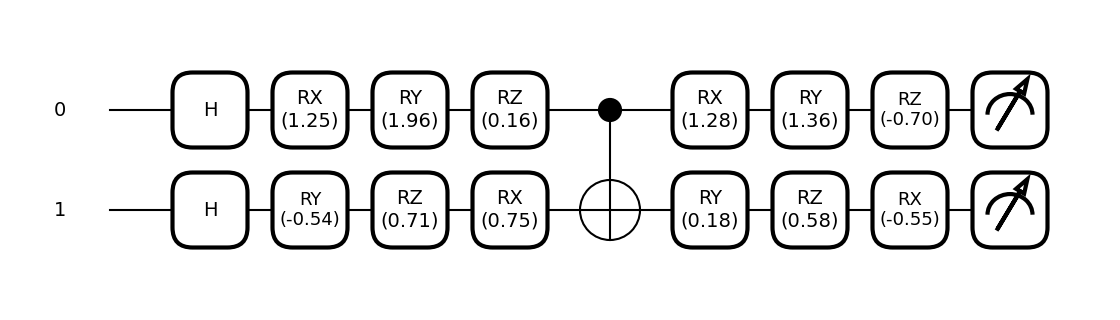

In [2]:
n_qubits = 2
n = 6*n_qubits
#alpha = init_state_rdm_ginibre(n_qubits)
target_vector, alpha = init_state_rsvg(n_qubits)

params = random_params(n)
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    qml.Hadamard(wires=1)
    qml.RY(params[3], wires=1)
    qml.RZ(params[4], wires=1)
    qml.RX(params[5], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RX(params[6], wires=0)
    qml.RY(params[7], wires=0)
    qml.RZ(params[8], wires=0)

    qml.RY(params[9], wires=1)
    qml.RZ(params[10], wires=1)
    qml.RX(params[11], wires=1)
    return qml.expval(qml.Hermitian(M, wires=[0,1]))
#drawer = qml.draw(circuit)
fig, ax = qml.draw_mpl(circuit, decimals=2)(params, alpha)
plt.show()

In [3]:
#def cost(params, alpha):
#    L = (1-(circuit(params, M=alpha)))**2
#    return L

def train(epocas, circuit, params, alpha):
    opt = torch.optim.Adam([params], lr=0.1)
    best_loss = 1*cost(circuit, params, alpha)
    best_params = 1*params
    f=[]
    for epoch in range(epocas):
        opt.zero_grad()
        loss = cost(circuit, params, alpha)
        print(epoch, loss.item())
        loss.backward()
        opt.step()
        if loss < best_loss:
            best_loss = 1*loss
            best_params = 1*params
        f.append(fidelidade(circuit, best_params, alpha))
    return best_params, f

0 0.7966957092285156
1 0.5595741271972656
2 0.2916421890258789
3 0.15106582641601562
4 0.07637882232666016
5 0.06397342681884766
6 0.060082435607910156
7 0.0742349624633789
8 0.06952285766601562
9 0.0791015625
10 0.06798648834228516
11 0.0629892349243164
12 0.050011634826660156
13 0.034066200256347656
14 0.016869544982910156
15 0.015625
16 0.011750221252441406
17 0.005654335021972656
18 0.006103515625
19 0.004540443420410156
20 0.006890296936035156
21 0.0087890625
22 0.011330604553222656
23 0.006569862365722656
24 0.009346961975097656
25 0.0095367431640625
26 0.006569862365722656
27 0.004540443420410156
28 0.00390625
29 0.00299072265625
30 0.0018463134765625
31 0.0028848648071289062
32 0.0016031265258789062
33 0.0011682510375976562
34 0.0019311904907226562
35 0.001682281494140625
36 0.001682281494140625
37 0.0014505386352539062
38 0.0009164810180664062
39 0.0010385513305664062
40 0.0014505386352539062
41 0.0009765625
42 0.0009164810180664062
43 0.0016031265258789062
44 0.00091648101806

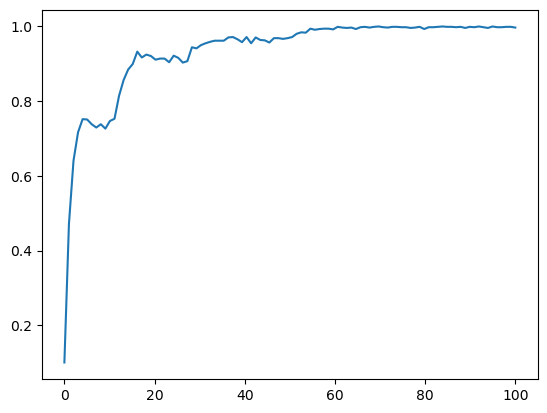

In [4]:


best_params, f = train(100, circuit, params, alpha)
x = np.linspace(0,len(f),len(f))
plt.plot(x,f)
plt.show()


In [5]:
print(fidelidade(circuit, best_params, alpha))

0.99609375


In [5]:
print(alpha)

tensor([[ 5.3717e-01+0.0000j, -2.2114e-01-0.0961j, -3.9313e-01-0.0090j,
          4.4217e-03-0.1893j],
        [-2.2114e-01+0.0961j,  1.0821e-01+0.0000j,  1.6346e-01-0.0666j,
          3.2028e-02+0.0787j],
        [-3.9313e-01+0.0090j,  1.6346e-01+0.0666j,  2.8787e-01+0.0000j,
         -5.8754e-05+0.1386j],
        [ 4.4217e-03+0.1893j,  3.2028e-02-0.0787j, -5.8754e-05-0.1386j,
          6.6745e-02+0.0000j]], dtype=torch.complex128)


In [6]:
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit_p(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    qml.Hadamard(wires=1)
    qml.RY(params[3], wires=1)
    qml.RZ(params[4], wires=1)
    qml.RX(params[5], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RX(params[6], wires=0)
    qml.RY(params[7], wires=0)
    qml.RZ(params[8], wires=0)

    qml.RY(params[9], wires=1)
    qml.RZ(params[10], wires=1)
    qml.RX(params[11], wires=1)
    return  qml.probs(wires=[0,1])
counts = circuit_p(best_params, M=alpha)
print(counts)

tensor([0.3750, 0.1289, 0.0996, 0.3965], dtype=torch.float64,
       grad_fn=<SqueezeBackward0>)


In [7]:
prepared_state = counts.detach().numpy()**0.5
print(target_vector)
print(alpha.detach().numpy())
print('------------------------')
print(prepared_state)
print(np.outer(prepared_state,prepared_state))

[ 0.45988049-0.45464466j  0.30083893-0.20214566j -0.17235223-0.24770214j
  0.46985534+0.3723111j ]
[[ 0.41819184+0.j          0.2302544 +0.04381197j  0.03335503-0.1922724j
   0.04680805+0.38483583j]
 [ 0.2302544 -0.04381197j  0.13136693+0.j         -0.00177835-0.1093587j
   0.06608971+0.20698489j]
 [ 0.03335503+0.1922724j  -0.00177835+0.1093587j   0.09106164+0.j
  -0.17320287+0.05221553j]
 [ 0.04680805-0.38483583j  0.06608971-0.20698489j -0.17320287-0.05221553j
   0.35937959+0.j        ]]
------------------------
[0.61237244 0.35903517 0.31560953 0.62967005]
[[0.375      0.21986324 0.19327058 0.38559258]
 [0.21986324 0.12890625 0.11331492 0.22607369]
 [0.19327058 0.11331492 0.09960937 0.19872987]
 [0.38559258 0.22607369 0.19872987 0.39648438]]


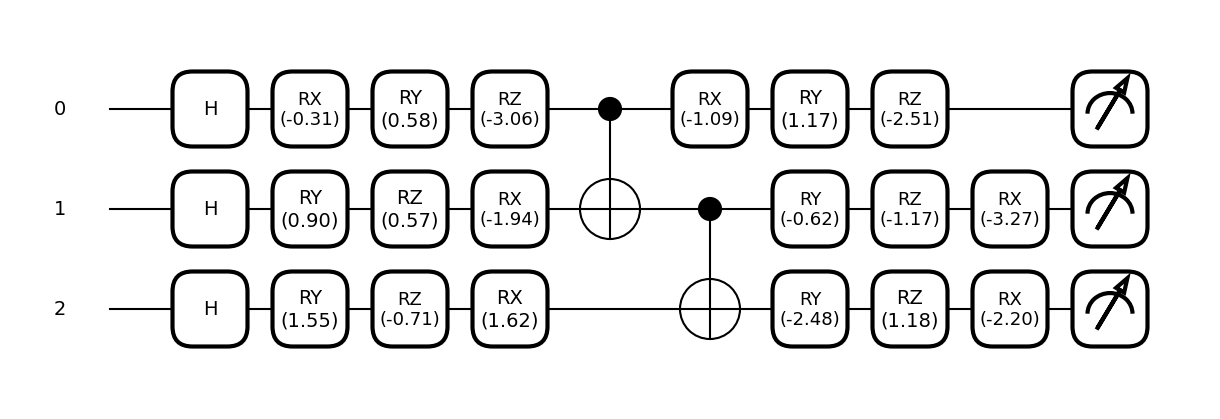

In [8]:
n_qubits = 3
n = 6*n_qubits
#alpha = init_state_rdm_ginibre(n_qubits)
target_vector, alpha = init_state_rsvg(n_qubits)

params = random_params(n)
device = get_device(n_qubits)


@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    qml.RY(params[3], wires=1)
    qml.RZ(params[4], wires=1)
    qml.RX(params[5], wires=1)
    qml.RY(params[6], wires=2)
    qml.RZ(params[7], wires=2)
    qml.RX(params[8], wires=2)

    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,2])
    qml.RX(params[9], wires=0)
    qml.RY(params[10], wires=0)
    qml.RZ(params[11], wires=0)
    qml.RY(params[12], wires=1)
    qml.RZ(params[13], wires=1)
    qml.RX(params[14], wires=1)
    qml.RY(params[15], wires=2)
    qml.RZ(params[16], wires=2)
    qml.RX(params[17], wires=2)

    return qml.expval(qml.Hermitian(M, wires=[0,1,2]))
#drawer = qml.draw(circuit)
fig, ax = qml.draw_mpl(circuit, decimals=2)(params, alpha)
plt.show()

0 0.8444604873657229
1 0.613407135009766
2 0.350223541259766
3 0.203556060791016
4 0.0940284729003909
5 0.04449462890625019
6 0.025028228759765767
7 0.01562500000000011
8 0.030899047851562656
9 0.052219390869140826
10 0.05177402496337911
11 0.07212162017822289
12 0.042057037353515805
13 0.056777954101562715
14 0.04870986938476582
15 0.03968811035156268
16 0.040470123291015805
17 0.0389137268066408
18 0.04086399078369159
19 0.03929996490478533
20 0.04700088500976582
21 0.027886390686035305
22 0.020328521728515753
23 0.014428138732910264
24 0.011750221252441503
25 0.014663696289062608
26 0.006569862365722728
27 0.005951881408691475
28 0.005802154541015693
29 0.008426666259765707
30 0.006729125976562573
31 0.005654335021972723
32 0.005222320556640689
33 0.0075540542602539834
34 0.01031494140625009
35 0.006412506103515696
36 0.010514259338378998
37 0.005364418029785221
38 0.0070533752441407
39 0.007897377014160236
40 0.007897377014160236
41 0.007897377014160236
42 0.005364418029785221
43 0

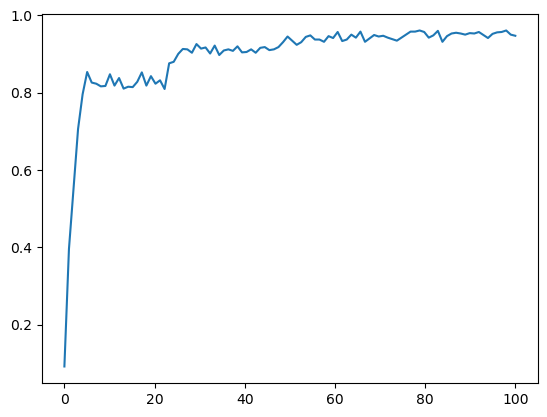

In [9]:
best_params, f = train(100, circuit, params, alpha)
x = np.linspace(0,len(f),len(f))
plt.plot(x,f)
plt.show()

In [10]:
prepared_state = counts.detach().numpy()**0.5
print(target_vector)
print(alpha.detach().numpy())
print('------------------------')
print(prepared_state)
print(np.outer(prepared_state,prepared_state))

[-0.05143146+0.29112606j -0.20594991-0.69488368j -0.47036985-0.10979781j
 -0.10207367+0.12078753j  0.14724429-0.12420427j -0.03908775-0.01132052j
 -0.14866149-0.16568987j -0.1992349 +0.03159436j]
[[ 0.08739958+0.j         -0.19170645+0.09569627j -0.0077732 +0.14258398j
   0.04041419+0.02350403j -0.04373209-0.03647864j -0.00128536+0.01196169j
  -0.04059076+0.05180091j  0.01944488+0.05637753j]
 [-0.19170645-0.09569627j  0.5252787 +0.j          0.17316933-0.30423948j
  -0.06291122-0.09580551j  0.05598257+0.12789751j  0.01591657-0.02482998j
   0.14575201-0.06917863j  0.01907801-0.14495193j]
 [-0.0077732 -0.14258398j  0.17316933+0.30423948j  0.23330335+0.j
   0.03475017-0.06802228j -0.05562192+0.07458904j  0.01962867+0.00103308j
   0.08811827+0.06161281j  0.0902451 -0.03673659j]
 [ 0.04041419-0.02350403j -0.06291122+0.09580551j  0.03475017+0.06802228j
   0.02500866+0.j         -0.03003209-0.00510729j  0.00262245+0.00587684j
  -0.00483885+0.03486903j  0.02415284+0.02084014j]
 [-0.04373209+0.

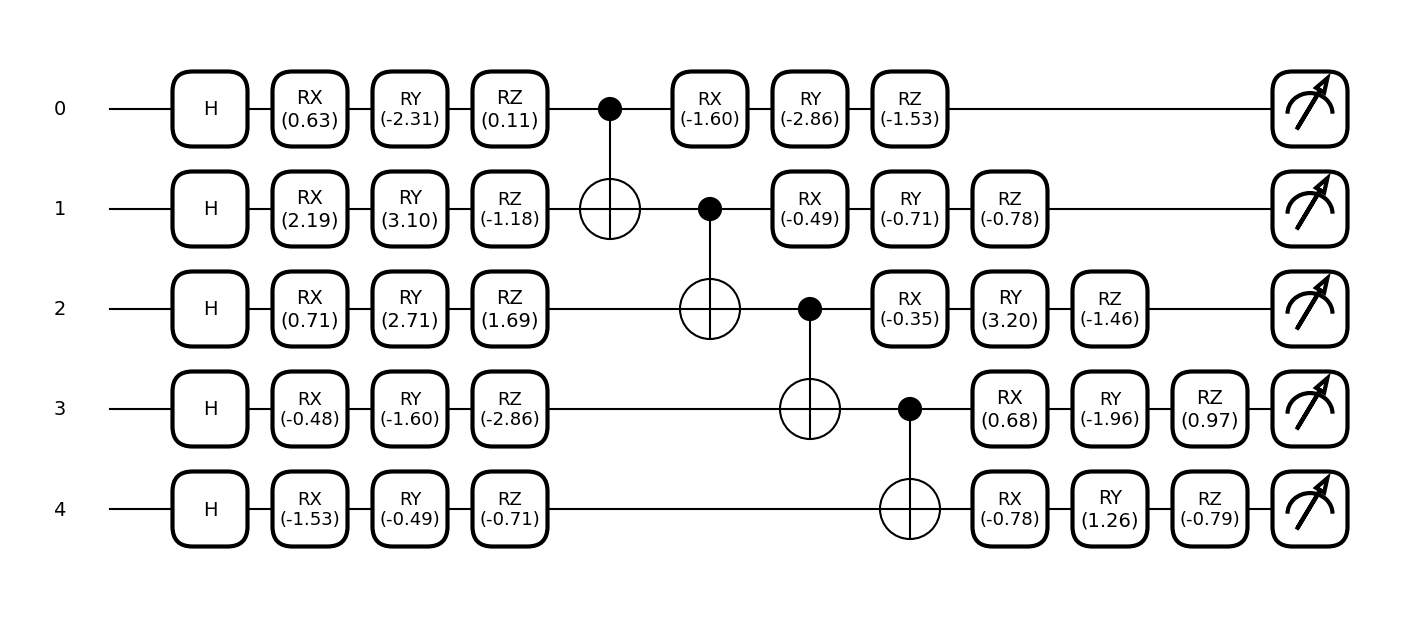

In [11]:
n_qubits = 5
n = 6*n_qubits
#alpha = init_state_rdm_ginibre(n_qubits)
target_vector, alpha = init_state_rsvg(n_qubits)

params = random_params(n)
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    #n_qubits = 5
    n = 6*n_qubits
    w = []

    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        w.append(i)

    aux = 0
    for j in range(n_qubits):
        qml.RX(params[j+aux], wires=j)
        qml.RY(params[j+1+aux], wires=j)
        qml.RZ(params[j+2+aux], wires=j)
        aux+=2
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i,i+1])
    for j in range(n_qubits):
        qml.RX(params[j+aux], wires=j)
        qml.RY(params[j+1+aux], wires=j)
        qml.RZ(params[j+2+aux], wires=j)
        aux+=2

    return qml.expval(qml.Hermitian(M, wires=w))
fig, ax = qml.draw_mpl(circuit, decimals=2)(params, alpha)
plt.show()


0 0.9922027587890625
1 0.9574928283691406
2 0.9252786636352539
3 0.8734216690063477
4 0.7914743423461914
5 0.7571039199829102
6 0.7673349380493164
7 0.7168664932250977
8 0.7086219787597656
9 0.6522455215454102
10 0.6585702896118164
11 0.6042633056640625
12 0.5831947326660156
13 0.55084228515625
14 0.5522928237915039
15 0.49851322174072266
16 0.47265625
17 0.4293832778930664
18 0.4179420471191406
19 0.3630533218383789
20 0.3142127990722656
21 0.3076782226562501
22 0.33762454986572266
23 0.33649063110351574
24 0.30443668365478527
25 0.2990722656250001
26 0.30228519439697277
27 0.3479156494140626
28 0.3076782226562501
29 0.3297271728515626
30 0.30984878540039074
31 0.3055152893066406
32 0.3252563476562501
33 0.30121231079101574
34 0.30228519439697277
35 0.3001413345336915
36 0.289536476135254
37 0.31093692779541027
38 0.324143409729004
39 0.2980051040649415
40 0.3208160400390626
41 0.27912235260009777
42 0.28534793853759777
43 0.30551528930664074
44 0.30443668365478527
45 0.27603530883789

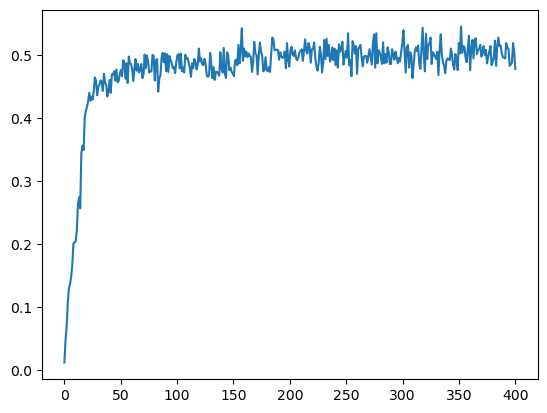

In [12]:
best_params, f = train(400, circuit, params, alpha)
x = np.linspace(0,len(f),len(f))
plt.plot(x,f)
plt.show()

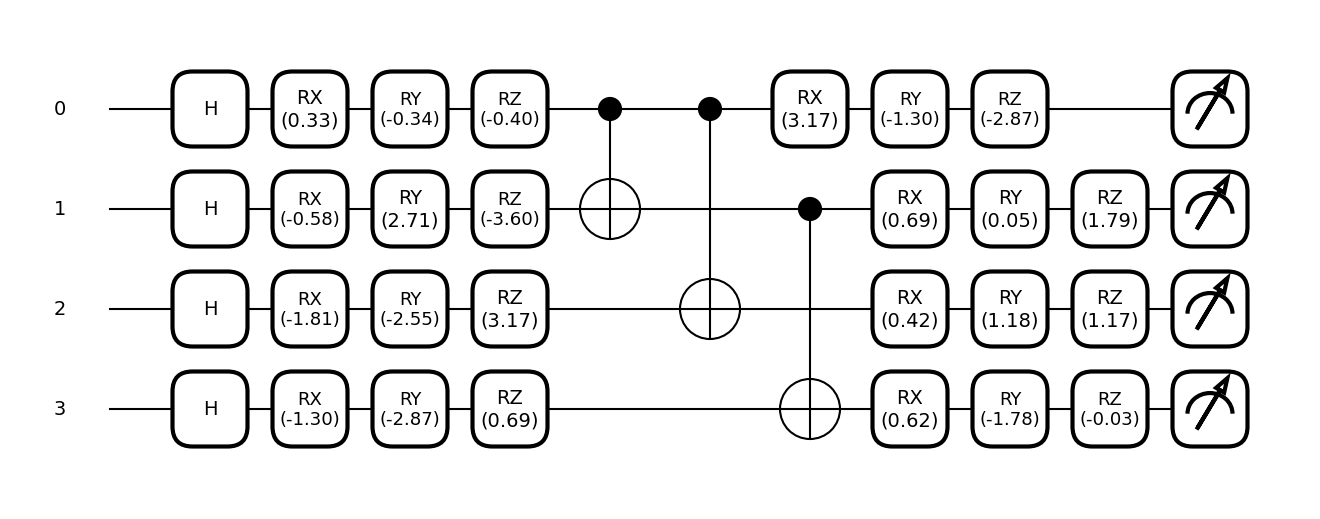

In [14]:
n_qubits = 4
n = 6*n_qubits
#alpha = init_state_rdm_ginibre(n_qubits)
target_vector, alpha = init_state_rsvg(n_qubits)

params = random_params(n)
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    n = 6*n_qubits
    w = []

    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        w.append(i)

    aux = 0
    for j in range(n_qubits):
        qml.RX(params[j+aux], wires=j)
        qml.RY(params[j+1+aux], wires=j)
        qml.RZ(params[j+2+aux], wires=j)
        aux+=2
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0,2])
    qml.CNOT(wires=[1,3])
#    for i in range(n_qubits-1):
#        qml.CNOT(wires=[i,i+1])
    for j in range(n_qubits):
        qml.RX(params[j+aux], wires=j)
        qml.RY(params[j+1+aux], wires=j)
        qml.RZ(params[j+2+aux], wires=j)
        aux+=2

    return qml.expval(qml.Hermitian(M, wires=w))
fig, ax = qml.draw_mpl(circuit, decimals=2)(params, alpha)
plt.show()

0 0.9177789688110352
1 0.7862701416015625
2 0.6890296936035156
3 0.5831947326660156
4 0.5772438049316406
5 0.5236444473266602
6 0.40665531158447266
7 0.3689613342285156
8 0.3571929931640625
9 0.3319740295410156
10 0.30767822265625
11 0.2729654312133789
12 0.25293827056884766
13 0.23937320709228516
14 0.25490665435791016
15 0.22248172760009766
16 0.20709609985351562
17 0.1658334732055664
18 0.1922616958618164
19 0.1746978759765625
20 0.1746978759765625
21 0.1495513916015625
22 0.1556549072265625
23 0.14654541015625
24 0.14879703521728516
25 0.1579751968383789
26 0.1457986831665039
27 0.12705326080322266
28 0.13698673248291016
29 0.1595315933227539


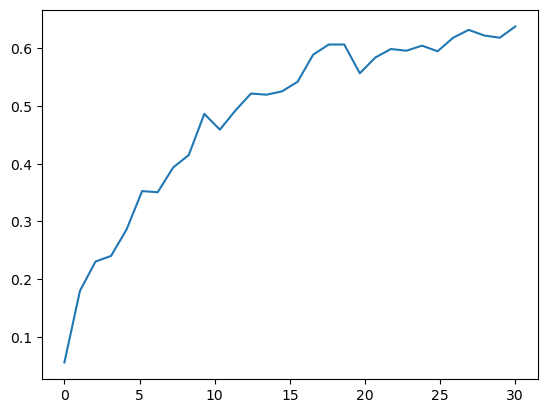

In [15]:
best_params, f = train(30, circuit, params, alpha)
x = np.linspace(0,len(f),len(f))
plt.plot(x,f)
plt.show()

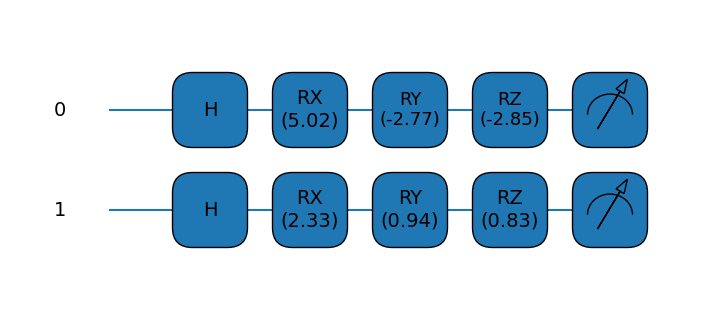

In [8]:

n_qubits = 3
device, params = device_and_random_params(n_qubits)
target_vector = init_state_exp_val(n_qubits)
@qml.qnode(device, interface="torch")
# def circuit(params, M=None):
#     qml.Hadamard(wires=0)
#     qml.RX(params[0], wires=0)
#     qml.RY(params[0], wires=0)
#     qml.RZ(params[0], wires=0)
#     qml.Hadamard(wires=1)
#     qml.RX(params[1], wires=1)
#     qml.RY(params[1], wires=1)
#     qml.RZ(params[1], wires=1)
#     return qml.expval(qml.Hermitian(M, wires=[0,1]))
# drawer = qml.draw(circuit)

def circuit(n_qubits, params, M=None):
    aux=0
    w = []
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RX(params[i+aux], wires=i)
        qml.RY(params[i+1+aux], wires=i)
        qml.RZ(params[i+2+aux], wires=i)
        w.append(i)
        aux+=2
    #qml.CNOT(wires=[0,1])
    return qml.expval(qml.Hermitian(M, wires=w))
#drawer = qml.draw(circuit)
fig, ax = qml.draw_mpl(circuit, decimals=2)(n_qubits, params,target_vector)
plt.show()

In [3]:
print(type(params))
print(len(params))
print(len(target_vector))
print(len(gen_paulis(2)))
print(np.shape(params))

<class 'torch.Tensor'>
3
3
6
torch.Size([3])


In [5]:
def cost(params, target_vector):
    size = len(params)
    Paulis = gen_paulis(2)
    L = 0
    for k in range(size):
        #print(k)
        L += torch.abs(circuit(n_qubits, params, Paulis[k]) - target_vector[k])
    return L
def train(epocas, params, target_vector):
    opt = torch.optim.Adam([params], lr=0.1)
    best_loss = 1*cost(params, target_vector)
    best_params = 1*params
    for epoch in range(epocas):
        opt.zero_grad()
        loss = cost(params, target_vector)
        print(epoch, loss.item())
        loss.backward()
        opt.step()
        if loss < best_loss:
            best_loss = 1*loss
            best_params = 1*params
    return best_params

best_params = train(30, params, target_vector)

0 0.7001682822876808
1 0.6220432822876807
2 0.5568120431742778
3 0.5294682931742778
4 0.5763432931742778
5 0.47673391817427785
6 0.42985891817427785
7 0.49040579317427785
8 0.5439182822876807
9 0.40134015728768074
10 0.49509015728768074
11 0.40134015728768074
12 0.37399640728768074
13 0.39938703228768074
14 0.36032453228768074
15 0.13571515728768074
16 0.18454328228768074
17 0.14274954317427785
18 0.05759015728768074
19 0.08791578850954268
20 0.19260642439613979
21 0.14963767439613979
22 0.17092546771231926
23 0.24924704939613979
24 0.20041892439613979
25 0.17307517439613979
26 0.14768454939613979
27 0.10862204939613979
28 0.05290579317427785
29 0.059793924396139786


In [5]:
print(best_params)

NameError: name 'best_params' is not defined

In [1]:
from multi_pure_prep import init_state_exp_val
from multi_pure_prep import train,gen_paulis
from multi_pure_prep import device_and_random_params
from multi_pure_prep import cost,circuit
import pennylane as qml


ModuleNotFoundError: No module named 'torch'

In [10]:
target_vector = init_state_exp_val(2)
device, params = device_and_random_params()
qc = circuit(params, target_vector)
#qnode = qml.QNode(qc, device=device, interface="torch")
#qnode = qml.QNode(circuit, device=device, interface="torch")
best_params = train(30, params)

TypeError: 'MeasurementProcess' object is not callable

In [ ]:
epochs, fidelity = train(30, circuit, params, cost(params, Paulis, target_vector))

In [ ]:
target_op, params = init_state_params()
best_params, best_loss = train(params,target_op)